# Ensemble Learning

## Initial Imports

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
from pathlib import Path
from collections import Counter
from datetime import datetime

In [34]:
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification

from imblearn.metrics import classification_report_imbalanced
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.ensemble import EasyEnsembleClassifier

## Read the CSV and Perform Basic Data Cleaning

In [4]:
# Load the data
file_path = Path('Resources/LoanStats_2019Q1.csv')
df = pd.read_csv(file_path)

# Preview the data
df.head()

,loan_amnt,int_rate,installment,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,dti,...,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,debt_settlement_flag
0,10500.0,0.1719,375.35,RENT,66000.0,Source Verified,Mar-2019,low_risk,n,27.24,...,85.7,100.0,0.0,0.0,65687.0,38199.0,2000.0,61987.0,N,N
1,25000.0,0.2000,929.09,MORTGAGE,105000.0,Verified,Mar-2019,low_risk,n,20.23,...,91.2,50.0,1.0,0.0,271427.0,60641.0,41200.0,49197.0,N,N
2,20000.0,0.2000,529.88,MORTGAGE,56000.0,Verified,Mar-2019,low_risk,n,24.26,...,66.7,50.0,0.0,0.0,60644.0,45684.0,7500.0,43144.0,N,N
3,10000.0,0.1640,353.55,RENT,92000.0,Verified,Mar-2019,low_risk,n,31.44,...,100.0,50.0,1.0,0.0,99506.0,68784.0,19700.0,76506.0,N,N
4,22000.0,0.1474,520.39,MORTGAGE,52000.0,Not Verified,Mar-2019,low_risk,n,18.76,...,100.0,0.0,0.0,0.0,219750.0,25919.0,27600.0,20000.0,N,N


In [5]:
df.columns

Index(['loan_amnt', 'int_rate', 'installment', 'home_ownership', 'annual_inc',
       'verification_status', 'issue_d', 'loan_status', 'pymnt_plan', 'dti',
       'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal',
       'total_acc', 'initial_list_status', 'out_prncp', 'out_prncp_inv',
       'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
       'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
       'last_pymnt_amnt', 'next_pymnt_d', 'collections_12_mths_ex_med',
       'policy_code', 'application_type', 'acc_now_delinq', 'tot_coll_amt',
       'tot_cur_bal', 'open_acc_6m', 'open_act_il', 'open_il_12m',
       'open_il_24m', 'mths_since_rcnt_il', 'total_bal_il', 'il_util',
       'open_rv_12m', 'open_rv_24m', 'max_bal_bc', 'all_util',
       'total_rev_hi_lim', 'inq_fi', 'total_cu_tl', 'inq_last_12m',
       'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util',
       'chargeoff_within_12_mths', 'delinq_amnt', 'mo_si

In [6]:
## Adding month and date columns from dates

# df["month"] = datetime.strptime(df["issue_d"], 'MMM-YYYY').month
# >>> print dt.year, dt.month, dt.day
df['issue_date'] = pd.to_datetime(df['issue_d'])
df['next_pymnt_date'] = pd.to_datetime(df['next_pymnt_d'])

df['issue_month'] = pd.DatetimeIndex(df['issue_date']).month.astype(str)
df["issue_year"] = pd.DatetimeIndex(df['issue_date']).year.astype(str)
df['next_pymnt_d_month'] = pd.DatetimeIndex(df['next_pymnt_date']).month.astype(str)
df['next_pymnt_d_year'] = pd.DatetimeIndex(df['next_pymnt_date']).year.astype(str)

In [7]:
df

,loan_amnt,int_rate,installment,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,dti,...,total_bc_limit,total_il_high_credit_limit,hardship_flag,debt_settlement_flag,issue_date,next_pymnt_date,issue_month,issue_year,next_pymnt_d_month,next_pymnt_d_year
0,10500.0,0.1719,375.35,RENT,66000.0,Source Verified,Mar-2019,low_risk,n,27.24,...,2000.0,61987.0,N,N,2019-03-01,2019-05-01,3,2019,5,2019
1,25000.0,0.2000,929.09,MORTGAGE,105000.0,Verified,Mar-2019,low_risk,n,20.23,...,41200.0,49197.0,N,N,2019-03-01,2019-05-01,3,2019,5,2019
2,20000.0,0.2000,529.88,MORTGAGE,56000.0,Verified,Mar-2019,low_risk,n,24.26,...,7500.0,43144.0,N,N,2019-03-01,2019-05-01,3,2019,5,2019
3,10000.0,0.1640,353.55,RENT,92000.0,Verified,Mar-2019,low_risk,n,31.44,...,19700.0,76506.0,N,N,2019-03-01,2019-05-01,3,2019,5,2019
4,22000.0,0.1474,520.39,MORTGAGE,52000.0,Not Verified,Mar-2019,low_risk,n,18.76,...,27600.0,20000.0,N,N,2019-03-01,2019-05-01,3,2019,5,2019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68812,10000.0,0.1502,346.76,RENT,26000.0,Source Verified,Jan-2019,low_risk,n,9.60,...,11300.0,5425.0,N,N,2019-01-01,2019-05-01,1,2019,5,2019
68813,12000.0,0.2727,368.37,RENT,63000.0,Not Verified,Jan-2019,low_risk,n,29.07,...,13500.0,62939.0,N,N,2019-01-01,2019-05-01,1,2019,5,2019
68814,5000.0,0.1992,185.62,MORTGAGE,52000.0,Source Verified,Jan-2019,low_risk,n,14.86,...,3600.0,18492.0,N,N,2019-01-01,2019-05-01,1,2019,5,2019
68815,40000.0,0.0646,1225.24,MORTGAGE,520000.0,Verified,Jan-2019,low_risk,n,9.96,...,100800.0,78634.0,N,N,2019-01-01,2019-05-01,1,2019,5,2019


## Split the Data into Training and Testing

In [8]:
# Create our features
X = df[['loan_amnt', 'int_rate', 'installment', 'home_ownership', 'annual_inc',
       'verification_status', 'issue_d', 'pymnt_plan', 'dti',
       'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal',
       'total_acc', 'initial_list_status', 'out_prncp', 'out_prncp_inv',
       'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
       'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
       'last_pymnt_amnt', 'next_pymnt_d', 'collections_12_mths_ex_med',
       'policy_code', 'application_type', 'acc_now_delinq', 'tot_coll_amt',
       'tot_cur_bal', 'open_acc_6m', 'open_act_il', 'open_il_12m',
       'open_il_24m', 'mths_since_rcnt_il', 'total_bal_il', 'il_util',
       'open_rv_12m', 'open_rv_24m', 'max_bal_bc', 'all_util',
       'total_rev_hi_lim', 'inq_fi', 'total_cu_tl', 'inq_last_12m',
       'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util',
       'chargeoff_within_12_mths', 'delinq_amnt', 'mo_sin_old_il_acct',
       'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl',
       'mort_acc', 'mths_since_recent_bc', 'mths_since_recent_inq',
       'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl',
       'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl',
       'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats', 'num_tl_120dpd_2m',
       'num_tl_30dpd', 'num_tl_90g_dpd_24m', 'num_tl_op_past_12m',
       'pct_tl_nvr_dlq', 'percent_bc_gt_75', 'pub_rec_bankruptcies',
       'tax_liens', 'tot_hi_cred_lim', 'total_bal_ex_mort', 'total_bc_limit',
       'total_il_high_credit_limit', 'hardship_flag','issue_month','issue_year',
       'next_pymnt_d_month','next_pymnt_d_year',"debt_settlement_flag"]]

# Create our target
y = df["loan_status"]

In [9]:
y.value_counts()

low_risk     68470
high_risk      347
Name: loan_status, dtype: int64

In [15]:
categorical = ["home_ownership","verification_status","pymnt_plan","application_type",
              "hardship_flag","initial_list_status",'issue_month','issue_year','next_pymnt_d_month','next_pymnt_d_year',
              "debt_settlement_flag"]

In [16]:
categorical_df = pd.get_dummies(df[categorical], prefix='d_')
categorical_df

,d__ANY,d__MORTGAGE,d__OWN,d__RENT,d__Not Verified,d__Source Verified,d__Verified,d__n,d__Individual,d__Joint App,...,d__f,d__w,d__1,d__2,d__3,d__2019,d__4,d__5,d__2019,d__N
0,0,0,0,1,0,1,0,1,1,0,...,0,1,0,0,1,1,0,1,1,1
1,0,1,0,0,0,0,1,1,1,0,...,0,1,0,0,1,1,0,1,1,1
2,0,1,0,0,0,0,1,1,1,0,...,0,1,0,0,1,1,0,1,1,1
3,0,0,0,1,0,0,1,1,1,0,...,0,1,0,0,1,1,0,1,1,1
4,0,1,0,0,1,0,0,1,1,0,...,0,1,0,0,1,1,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68812,0,0,0,1,0,1,0,1,1,0,...,0,1,1,0,0,1,0,1,1,1
68813,0,0,0,1,1,0,0,1,1,0,...,0,1,1,0,0,1,0,1,1,1
68814,0,1,0,0,0,1,0,1,1,0,...,0,1,1,0,0,1,0,1,1,1
68815,0,1,0,0,0,0,1,1,1,0,...,1,0,1,0,0,1,0,1,1,1


In [17]:
print(X.shape)

(68817, 89)


In [18]:
X_new = pd.concat([X, categorical_df], axis="columns")
X_new.drop(categorical, axis="columns", inplace=True)
X_new.drop('issue_d', axis="columns", inplace=True)
X_new.drop('next_pymnt_d', axis="columns", inplace=True)
X = X_new

In [19]:
print(X.shape)

(68817, 97)


In [20]:
X.describe()

,loan_amnt,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,...,d__f,d__w,d__1,d__2,d__3,d__2019,d__4,d__5,d__2019,d__N
count,68817.000000,68817.000000,68817.000000,6.881700e+04,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,...,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.0,68817.000000,68817.000000,68817.0,68817.0
mean,16677.594562,0.127718,480.652863,8.821371e+04,21.778153,0.217766,0.497697,12.587340,0.126030,17604.142828,...,0.123879,0.876121,0.451066,0.371696,0.177238,1.0,0.383161,0.616839,1.0,1.0
std,10277.348590,0.048130,288.062432,1.155800e+05,20.199244,0.718367,0.758122,6.022869,0.336797,21835.880400,...,0.329446,0.329446,0.497603,0.483261,0.381873,0.0,0.486161,0.486161,0.0,0.0
min,1000.000000,0.060000,30.890000,4.000000e+01,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,1.0,1.0
25%,9000.000000,0.088100,265.730000,5.000000e+04,13.890000,0.000000,0.000000,8.000000,0.000000,6293.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,1.0,1.0
50%,15000.000000,0.118000,404.560000,7.300000e+04,19.760000,0.000000,0.000000,11.000000,0.000000,12068.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,1.0,0.000000,1.000000,1.0,1.0
75%,24000.000000,0.155700,648.100000,1.040000e+05,26.660000,0.000000,1.000000,16.000000,0.000000,21735.000000,...,0.000000,1.000000,1.000000,1.000000,0.000000,1.0,1.000000,1.000000,1.0,1.0
max,40000.000000,0.308400,1676.230000,8.797500e+06,999.000000,18.000000,5.000000,72.000000,4.000000,587191.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.0,1.0


In [21]:
# Check the balance of our target values
print(len(X))
print(len(y))

68817
68817


In [22]:
X

,loan_amnt,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,...,d__f,d__w,d__1,d__2,d__3,d__2019,d__4,d__5,d__2019,d__N
0,10500.0,0.1719,375.35,66000.0,27.24,0.0,0.0,8.0,0.0,1609.0,...,0,1,0,0,1,1,0,1,1,1
1,25000.0,0.2000,929.09,105000.0,20.23,0.0,0.0,17.0,1.0,18368.0,...,0,1,0,0,1,1,0,1,1,1
2,20000.0,0.2000,529.88,56000.0,24.26,0.0,0.0,8.0,0.0,13247.0,...,0,1,0,0,1,1,0,1,1,1
3,10000.0,0.1640,353.55,92000.0,31.44,0.0,1.0,10.0,1.0,17996.0,...,0,1,0,0,1,1,0,1,1,1
4,22000.0,0.1474,520.39,52000.0,18.76,0.0,1.0,14.0,0.0,9091.0,...,0,1,0,0,1,1,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68812,10000.0,0.1502,346.76,26000.0,9.60,0.0,0.0,9.0,0.0,2684.0,...,0,1,1,0,0,1,0,1,1,1
68813,12000.0,0.2727,368.37,63000.0,29.07,0.0,0.0,8.0,0.0,13314.0,...,0,1,1,0,0,1,0,1,1,1
68814,5000.0,0.1992,185.62,52000.0,14.86,0.0,0.0,5.0,1.0,3715.0,...,0,1,1,0,0,1,0,1,1,1
68815,40000.0,0.0646,1225.24,520000.0,9.96,0.0,1.0,21.0,0.0,59529.0,...,1,0,1,0,0,1,0,1,1,1


In [23]:
X.to_csv("view.csv")

In [24]:
# Split the X and y into X_train, X_test, y_train, y_test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=32)

## Data Pre-Processing

Scale the training and testing data using the `StandardScaler` from `sklearn`. Remember that when scaling the data, you only scale the features data (`X_train` and `X_testing`).

In [25]:
# Create the StandardScaler instance
scaler = StandardScaler()

In [26]:
X_train.head()

,loan_amnt,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,...,d__f,d__w,d__1,d__2,d__3,d__2019,d__4,d__5,d__2019,d__N
63152,15000.0,0.2235,417.28,125000.0,11.06,0.0,2.0,10.0,2.0,9550.0,...,0,1,1,0,0,1,0,1,1,1
2905,40000.0,0.1033,856.40,105000.0,15.02,0.0,1.0,13.0,0.0,34395.0,...,0,1,0,0,1,1,0,1,1,1
27484,12925.0,0.1691,460.24,55000.0,13.81,0.0,2.0,9.0,0.0,8524.0,...,0,1,0,1,0,1,0,1,1,1
12354,10000.0,0.1474,345.39,70000.0,9.19,0.0,1.0,9.0,1.0,2352.0,...,1,0,0,1,0,1,0,1,1,1
4134,15000.0,0.1171,496.14,85000.0,10.29,0.0,0.0,8.0,0.0,1701.0,...,0,1,0,0,1,1,0,1,1,1


In [27]:
# Fit the Standard Scaler with the training data
# When fitting scaling functions, only train on the training dataset
X_scaler = scaler.fit(X_train)
# scaler_test = StandardScaler().fit(X_test)

In [28]:
# Scale the training and testing data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

## Ensemble Learners

In this section, you will compare two ensemble algorithms to determine which algorithm results in the best performance. You will train a Balanced Random Forest Classifier and an Easy Ensemble classifier . For each algorithm, be sure to complete the folliowing steps:

1. Train the model using the training data. 
2. Calculate the balanced accuracy score from sklearn.metrics.
3. Display the confusion matrix from sklearn.metrics.
4. Generate a classication report using the `imbalanced_classification_report` from imbalanced-learn.
5. For the Balanced Random Forest Classifier only, print the feature importance sorted in descending order (most important feature to least important) along with the feature score

Note: Use a random state of 1 for each algorithm to ensure consistency between tests

### Balanced Random Forest Classifier

In [35]:
# Resample the training data with the BalancedRandomForestClassifier
brfc = BalancedRandomForestClassifier(max_depth=2, random_state=1)
brfc.fit(X_train, y_train)  

BalancedRandomForestClassifier(max_depth=2, random_state=1)

In [36]:
# Calculated the balanced accuracy score
y_pred = brfc.predict(X_test)
balanced_accuracy_score(y_test, y_pred)

0.7147418320530224

In [37]:
# Display the confusion matrix
confusion_matrix(y_test, y_pred)

array([[   38,    44],
       [  581, 16542]])

In [38]:
# Print the imbalanced classification report
print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.06      0.46      0.97      0.11      0.67      0.43        82
   low_risk       1.00      0.97      0.46      0.98      0.67      0.47     17123

avg / total       0.99      0.96      0.47      0.98      0.67      0.47     17205



<AxesSubplot:title={'center':'Features Importances'}, ylabel='1'>

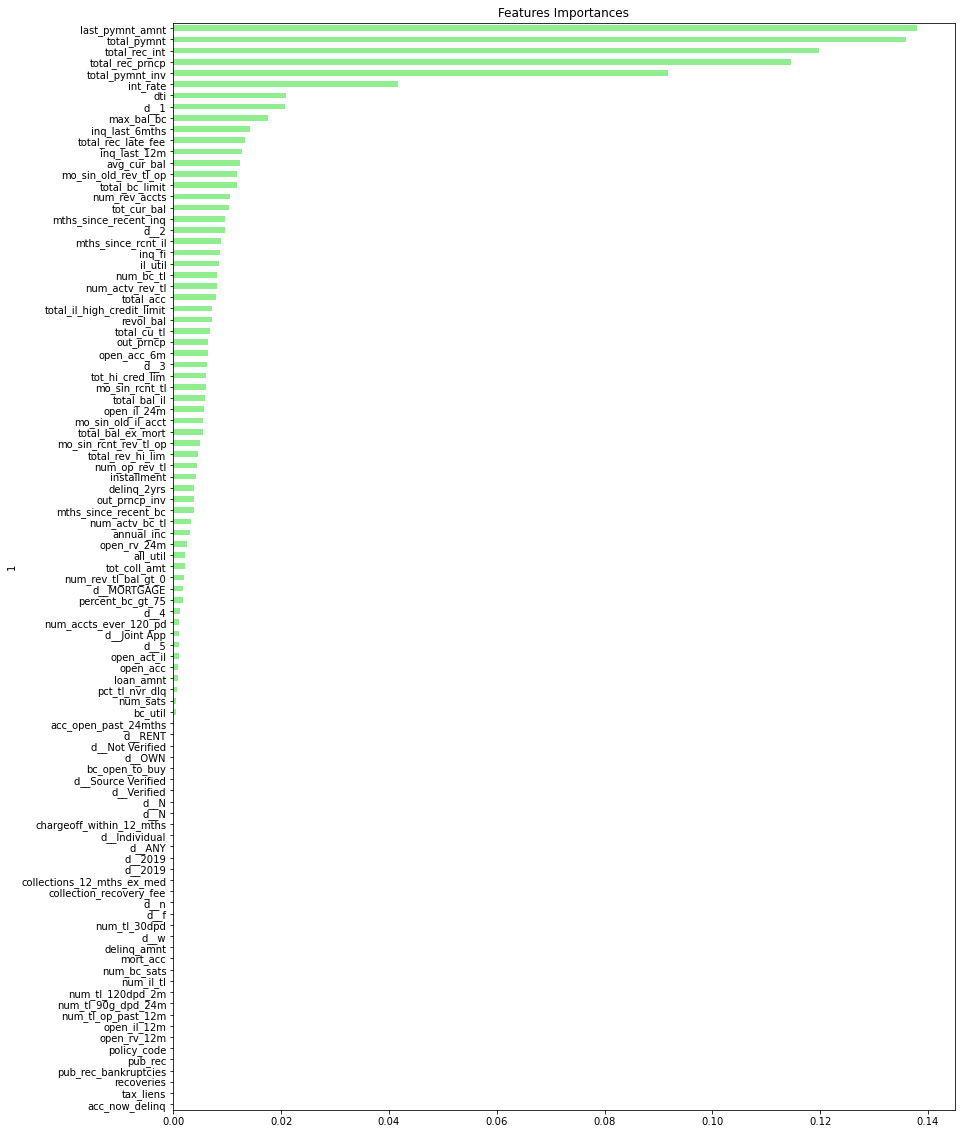

In [39]:
# List the features sorted in descending order by feature importance
importances_df = pd.DataFrame(sorted(zip(clf.feature_importances_, X.columns), reverse=True))
importances_df.set_index(importances_df[1], inplace=True)
importances_df.drop(columns=1, inplace=True)
importances_df.rename(columns={0: 'Feature Importances'}, inplace=True)
importances_sorted = importances_df.sort_values(by='Feature Importances', ascending=True)
importances_sorted.plot(kind='barh', color='lightgreen', title= 'Features Importances', legend=False, figsize=(14,20))

### Easy Ensemble Classifier

In [46]:
# Train the Classifier
eec = EasyEnsembleClassifier(random_state=1)
eec.fit(X_train, y_train)  

EasyEnsembleClassifier(random_state=1)

In [47]:
# Calculated the balanced accuracy score
y_pred = eec.predict(X_test)
balanced_accuracy_score(y_test, y_pred)

0.9197705838531258

In [48]:
# Display the confusion matrix
confusion_matrix(y_test, y_pred)

array([[   74,     8],
       [ 1077, 16046]])

In [49]:
# Print the imbalanced classification report
print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.06      0.90      0.94      0.12      0.92      0.84        82
   low_risk       1.00      0.94      0.90      0.97      0.92      0.85     17123

avg / total       1.00      0.94      0.90      0.96      0.92      0.85     17205



In [52]:
print(np.mean([est.steps[1][1].feature_importances_ for est in eec.estimators_], axis=0))

[0.014 0.068 0.076 0.    0.008 0.002 0.006 0.002 0.    0.002 0.002 0.016
 0.014 0.022 0.026 0.096 0.168 0.018 0.    0.    0.106 0.    0.    0.
 0.004 0.004 0.004 0.002 0.    0.    0.008 0.004 0.    0.    0.    0.012
 0.006 0.002 0.004 0.    0.    0.002 0.006 0.016 0.016 0.    0.    0.002
 0.01  0.    0.004 0.002 0.006 0.002 0.    0.    0.    0.    0.002 0.002
 0.002 0.    0.002 0.004 0.    0.    0.    0.004 0.    0.002 0.    0.
 0.004 0.004 0.008 0.    0.    0.    0.    0.    0.002 0.    0.    0.
 0.    0.    0.    0.    0.    0.078 0.004 0.048 0.    0.034 0.038 0.
 0.   ]


### Final Questions

1. Which model had the best balanced accuracy score?

    Easy Ensemble Classifier with 0.9197

2. Which model had the best recall score?

    Balanced Random Forest Classifier with 0.96 (96%)

3. Which model had the best geometric mean score?

    Easy Ensemble Classifier with 0.92

4. What are the top three features?

    last_paymnt_amt, total_payment, total_rec_int